# Modelling

In this notebook, we will train and fine-tune the models selected in the previous notebook using the prepared dataset and the optimized hyperparameters. Following  models will be trained and tuned:

- HistGradientBoostingRegressor
- KNeighborsRegressor
- LassoLarsICRegressor
- XGBRegressor

The goal is to combine these models into a StackingRegressor to improve the predictive performance. We will use the **Ridge** model as the final estimator.

## Load Data

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from src.features.helpers.load_data import load_data
from src.models.model_2.model.pipelines import pipeline
import pandas as pd

train_data, augmented_data, test_data = load_data('1_00h')

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, augmented_data]))

X_train = all_train_data_transformed.iloc[:len(train_data)].drop(columns=['bg+1:00'])
y_train = all_train_data_transformed.iloc[:len(train_data)]['bg+1:00']

X_augmented = all_train_data_transformed.iloc[len(train_data):].drop(columns=['bg+1:00'])
y_augmented = all_train_data_transformed.iloc[len(train_data):]['bg+1:00']

X_augmented_train, X_augmented_val, y_augmented_train, y_augmented_val = train_test_split(X_augmented, y_augmented, test_size=0.2)

X_train = pd.concat([X_train, X_augmented_train])
y_train = pd.concat([y_train, y_augmented_train])

X_test = pipeline.transform(test_data)

### Model Setup

In [3]:
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor

hgb_base_estimator = HistGradientBoostingRegressor(
    l2_regularization=0.0001,
    learning_rate=0.1,
    max_depth=11,
    max_iter=1500,
    min_samples_leaf=10,
    n_iter_no_change=22,
    random_state=42,
)

lasso_lars_ic_base_estimator = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

knn_base_estimator = KNeighborsRegressor(
    leaf_size=30,
    metric='minkowski',
    n_neighbors=7,
    p=2,
    weights='uniform'
)

xgb_base_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=10.0,
    reg_alpha=1.0,
    objective='reg:squarederror',
    random_state=42,
)

estimators = [
    ('hgb', hgb_base_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_estimator),
    ('knn', knn_base_estimator),
    ('xgb', xgb_base_estimator),
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=0
)

## Performance Calculations with Cross Validation

Final estimator RMSE: 1.4956417733797829
Final estimator R2: 0.7847963155567121
Final estimator MSE: 2.2369870974974537
Final estimator MAE: 1.1116463866250015


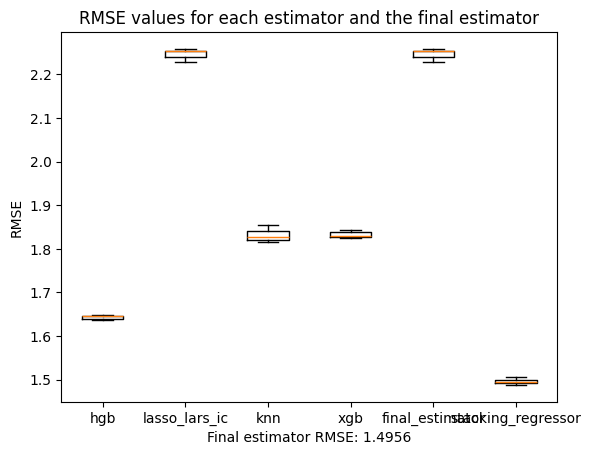

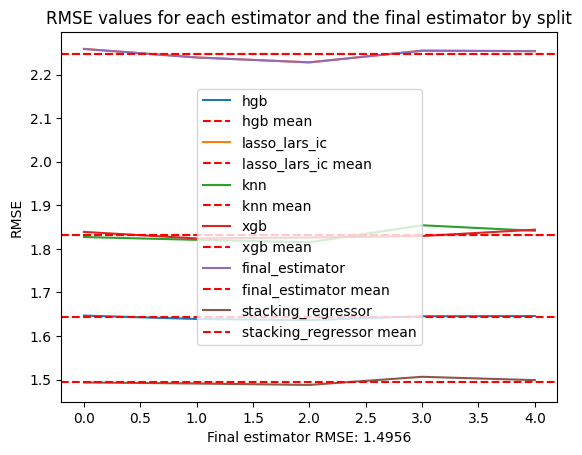

In [4]:
from datetime import datetime
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-baseline-model'

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_augmented_train, y_augmented_train, verbose=False)

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

## Train the model with all data and predict for test data


In [5]:
import numpy as np

model.fit(pd.concat([X_train, X_augmented_train]), pd.concat([y_train, y_augmented_train]))
y_pred = model.predict(X_test)

# do a sanity check, we should not have negative values
if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    y_pred = y_pred.apply(lambda x: bg_min_train if x < 0 else x)

test_data['bg+1:00'] = y_pred

## Save the predictions for submission

In [6]:
import os

submission = pd.DataFrame(test_data['bg+1:00'])
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')
submission

,bg+1:00
id,
p01_8459,8.756893
p01_8460,5.118244
p01_8461,7.710794
p01_8462,11.345586
p01_8463,6.470444
...,...
p24_256,5.809733
p24_257,8.780385
p24_258,5.700356
